기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
from sklearn.preprocessing import MinMaxScaler

https://wikidocs.net/31379

# 트랜스포머 구현

![어텐션](./img/transformer/attention.png)

> 인코더의 셀프 어텐션 : Query = Key = Value  
> 디코더의 마스크드 셀프 어텐션 : Query = Key = Value  
> 디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터  

![트랜스포머 어텐션](./img/transformer/transformer_attention.png)


## 에셋 임베딩 레이어

In [4]:
class AssetAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, d_model, is_decoder=False, **kwargs):
        super(AssetAndPositionEmbedding, self).__init__(**kwargs)
        self.esset_emb = tf.keras.layers.Dense(d_model) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(window_size, d_model)
        self.is_decoder = is_decoder
        self.__windowsize = window_size

    def call(self, x):
        L = tf.shape(x)[1] if self.is_decoder else self.__windowsize
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        x = tf.reshape(x,(-1,L,1))
        x = self.esset_emb(x)
        return x + positions

In [5]:
emb = AssetAndPositionEmbedding(6,10)
x = tf.constant([[1.1,2.1,3.1,4.1,5.1,6.1],
                 [1.2,2.2,3.2,4.2,5.2,6.2],
                 [1.3,2.3,3.3,4.3,5.3,6.3]])

emb(x)

2022-08-12 15:55:13.718153: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-12 15:55:13.718407: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.73.5 does not match DSO version 510.85.2 -- cannot find working devices in this configuration


<tf.Tensor: shape=(3, 6, 10), dtype=float32, numpy=
array([[[-0.7626514 ,  0.06600738,  0.6175116 ,  0.6773592 ,
          0.28096905,  0.12003164,  0.6391505 , -0.68458176,
          0.13990554, -0.05899153],
        [-1.3869025 ,  0.11892799,  1.087841  ,  1.2746544 ,
          0.58579004,  0.278071  ,  1.0975966 , -1.1932437 ,
          0.23993745, -0.12862742],
        [-2.0479794 ,  0.21939218,  1.6015749 ,  1.8783814 ,
          0.8437731 ,  0.47575694,  1.6404608 , -1.7796018 ,
          0.33237785, -0.23655634],
        [-2.7628946 ,  0.3191094 ,  2.1366212 ,  2.4812603 ,
          1.1538954 ,  0.54674375,  2.222357  , -2.3998227 ,
          0.41639355, -0.31661367],
        [-3.3994963 ,  0.31465963,  2.6615162 ,  3.0910518 ,
          1.4054873 ,  0.69505733,  2.7239983 , -3.0369875 ,
          0.5601434 , -0.3666273 ],
        [-4.1352406 ,  0.40473208,  3.149909  ,  3.7425165 ,
          1.7326988 ,  0.8675406 ,  3.294387  , -3.5499935 ,
          0.5921987 , -0.5439529 ]],

## 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

인코더의 셀프 어텐션 : Query = Key = Value

>Q = Query : t 시점의 디코더 셀에서의 은닉 상태  
>K = Keys : 모든 시점의 인코더 셀의 은닉 상태들  
>V = Values : 모든 시점의 인코더 셀의 은닉 상태들  

![인코더 어텐션1](./img/transformer/encoder-attention1.png)    ![인코더 어텐션2](./img/transformer/encoder-attention2.png)

In [6]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

## 멀티 헤드 어텐션(Multi-head Attention)

![멀티헤드 어텐션1](./img/transformer/multihead-attention1.png)  
![멀티헤드 어텐션2](./img/transformer/multihead-attention2.png)  
![멀티헤드 어텐션3](./img/transformer/multihead-attention3.png)  

In [7]:
#생각 못한부분!!
#enc_output : (batch_size, 25, d_model)
#dec_output : (batch_size, 20, d_model)
#어떻게 맞출까?

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

## 인코더 레이어

In [8]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': None
    })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [9]:
def encoder(window_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = AssetAndPositionEmbedding(window_size,d_model)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}",)([outputs])

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## 셀프 어텐션(Self-attention)과 룩-어헤드 마스크(Look-ahead mask)

In [10]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return look_ahead_mask[tf.newaxis,tf.newaxis,:,:]

In [11]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 디코더 레이어

In [12]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': look_ahead_mask # 룩어헤드 마스크
    })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
        'mask': None # 패딩 마스크
    })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [13]:
def decoder(forecast_range, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = AssetAndPositionEmbedding(forecast_range,d_model,is_decoder=True)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

## 트랜스포머(Transformer)

In [14]:
def transformer(window_size, forecast_range, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크X

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크X

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[inputs]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(forecast_range=forecast_range, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask])

    # 다음 단어 예측을 위한 출력층
    #outputs = tf.keras.layers.Dense(units=forecast_range, name="outputs")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 데이터 셋 만들기

## ABBV 데이터

In [15]:
ABBV = pd.read_csv("./stock/asset/ABBV.csv")
ABBV

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-14,117.360001,117.589996,116.379997,116.430000,110.615051,6268500
1,2021-05-17,116.769997,117.709999,116.559998,116.889999,111.052071,6183200
2,2021-05-18,116.110001,117.900002,115.320000,117.209999,111.356102,8174900
3,2021-05-19,116.459999,116.500000,114.379997,115.849998,110.064026,6433600
4,2021-05-20,115.339996,117.339996,115.120003,117.110001,111.261101,5526100
...,...,...,...,...,...,...,...
295,2022-07-18,153.800003,154.470001,148.889999,149.570007,149.570007,6838400
296,2022-07-19,150.000000,150.229996,148.800003,149.740005,149.740005,5647100
297,2022-07-20,149.529999,150.449997,147.339996,147.690002,147.690002,5315700
298,2022-07-21,147.240005,147.839996,146.020004,147.750000,147.750000,4066800


In [16]:
class one_asset:
    def __init__(self, asset_dataframe, X_col=["Adj Close"], window_size=20 ,H = 1, train_test_ratio = 0.8, is_minmaxscale = False):
        self.origin_data = asset_dataframe
        self.X_col = X_col
        self.window_size = window_size
        self.H = H
        self.train_test_ratio = train_test_ratio
        self.__split_point = int(self.origin_data.shape[0]*0.7)
        self.train_scaler = MinMaxScaler(feature_range = (-1,+1)) if is_minmaxscale else None
        self.test_scaler = MinMaxScaler(feature_range = (-1,+1)) if is_minmaxscale else None
        
        self.dataframe = self.origin_data.drop(columns="Date").copy()
        self.dataframe.fillna(method='ffill',inplace=True)
        self.dataframe.fillna(method='bfill',inplace=True)

    def get_data(self, is_train = True):
        #Adj close가 X로 들어가는지 여부 체크(스케일러용)
        if "Adj Close" not in self.X_col:
            cols = self.X_col
            cols.append("Adj Close")
        else:
            cols = self.X_col
        
        
        if is_train:
            dataframe = self.dataframe.iloc[:self.__split_point,:].copy()
            dataframe = dataframe[cols].copy()
            if self.train_scaler is not None:
                self.train_scaler.fit(dataframe)
                dataframe = self.train_scaler.transform(dataframe)
                dataframe = pd.DataFrame(dataframe,columns = cols)
        else:
            dataframe = self.dataframe.iloc[self.__split_point-self.window_size-self.H-1:,:].copy()
            dataframe = dataframe[cols].copy()
            if self.test_scaler is not None:
                self.test_scaler.fit(dataframe)
                dataframe = self.test_scaler.transform(dataframe)
                dataframe = pd.DataFrame(dataframe,columns = cols)

        X_data = dataframe[self.X_col].iloc[:-self.H,:].copy()
        Y_data = dataframe[["Adj Close"]].iloc[self.H + self.window_size-1:,:].copy()

        return X_data.to_numpy(), Y_data.to_numpy()

    def get_data_for_model(self, is_train = True, is_shuffle=True):
        X_np,Y_np = self.get_data(is_train = is_train)
        if is_train:
            start_point_array = np.arange(Y_np.shape[0])
            if is_shuffle:
                np.random.shuffle(start_point_array)
            X_data = []
            for sp in start_point_array:
                X_data.append(list(X_np[sp:sp+self.window_size]))
            X_data = np.array(X_data)
            Y_data = Y_np[start_point_array]

            return X_data, Y_data
        else:
            start_point_array = np.arange(Y_np.shape[0])
            X_data = []
            for sp in start_point_array:
                X_data.append(X_np[sp:sp+self.window_size])
            X_data = np.array(X_data)
            Y_data = Y_np

            return X_data, Y_data

    def get_data_long_y(self, length_y = 21 ,is_train = True, is_shuffle=True):
        X_np,Y_np = self.get_data(is_train = is_train)
        Y_np = np.concatenate([X_np[-Y_np.shape[0]].reshape((1,1)),Y_np.reshape((-1,1))],axis=0)
        if is_train:
            start_point_array = np.arange(Y_np.shape[0])
            for ind in start_point_array:
                if ind+length_y > Y_np.shape[0]:
                    start_point_array = start_point_array[start_point_array != ind]
            
            if is_shuffle:
                np.random.shuffle(start_point_array)
            X_data = []
            for sp in start_point_array:
                X_data.append(list(X_np[sp:sp+self.window_size]))
            X_data = np.array(X_data)
            
            Y_data = []
            for sp in start_point_array:
                Y_data.append(list(Y_np[sp:sp+length_y]))
            Y_data = np.array(Y_data)
            
            return X_data, Y_data
        else:
            start_point_array = np.arange(Y_np.shape[0])
            for ind in start_point_array:
                if ind+length_y > Y_np.shape[0]:
                    start_point_array = start_point_array[start_point_array != ind]
            X_data = []
            for sp in start_point_array:
                X_data.append(X_np[sp:sp+self.window_size])
            X_data = np.array(X_data)
            
            Y_data = []
            for sp in start_point_array:
                Y_data.append(list(Y_np[sp:sp+length_y]))
            Y_data = np.array(Y_data)

            return X_data, Y_data

In [17]:
abbv_1 = one_asset(ABBV,X_col=["Adj Close"], 
                   window_size=25 ,
                   H = 1, 
                   train_test_ratio = 1, 
                   is_minmaxscale = True)
X,Y = abbv_1.get_data(is_train = True)
print(X.shape, Y.shape)
X_1,Y_1 = abbv_1.get_data_for_model(is_train = True)
print(X_1.shape,Y_1.shape)
X_2,Y_2 = abbv_1.get_data_long_y(length_y = 21,is_train = True,is_shuffle=False)
print(X_2.shape,Y_2.shape)

(209, 1) (185, 1)
(185, 25, 1) (185, 1)
(166, 25, 1) (166, 21, 1)


In [18]:
X_2[:2,:,:].squeeze()

array([[-0.64403494, -0.62552015, -0.61263955, -0.66737971, -0.61666437,
        -0.65651216, -0.66496455, -0.71930229, -0.71366747, -0.809463  ,
        -0.7740431 , -0.81389056, -0.84649289, -0.81389056, -0.80785235,
        -0.78169001, -0.80865816, -0.74184255, -0.65168282, -0.68468756,
        -0.68549239, -0.66818454, -0.68025999, -0.70561782, -0.77726245],
       [-0.62552015, -0.61263955, -0.66737971, -0.61666437, -0.65651216,
        -0.66496455, -0.71930229, -0.71366747, -0.809463  , -0.7740431 ,
        -0.81389056, -0.84649289, -0.81389056, -0.80785235, -0.78169001,
        -0.80865816, -0.74184255, -0.65168282, -0.68468756, -0.68549239,
        -0.66818454, -0.68025999, -0.70561782, -0.77726245, -0.7124599 ]])

In [19]:
Y_2[0,:,:].squeeze()

array([-0.77726245, -0.7124599 , -0.71366747, -0.74184255, -0.71205748,
       -0.78289791, -0.78209275, -0.81026783, -0.79658271, -0.73137742,
       -0.69474995, -0.67221002, -0.63115498, -0.6472546 , -0.63799705,
       -0.59573476, -0.58446447, -0.55394017, -0.56126612, -0.54824265,
       -0.6328962 ])

In [20]:
Y_2.squeeze()[0, :-1]

array([-0.77726245, -0.7124599 , -0.71366747, -0.74184255, -0.71205748,
       -0.78289791, -0.78209275, -0.81026783, -0.79658271, -0.73137742,
       -0.69474995, -0.67221002, -0.63115498, -0.6472546 , -0.63799705,
       -0.59573476, -0.58446447, -0.55394017, -0.56126612, -0.54824265])

In [21]:
total_dataset_X = []
total_dataset_Y = []
scaler_list=[]
M6_Universe = pd.read_csv('M6_Universe.csv')
for asset in M6_Universe.symbol:
    tmp = pd.read_csv(f"./stock/asset/{asset}.csv")
    tmp = one_asset(tmp,X_col=["Adj Close"], 
                    window_size=25 ,
                    train_test_ratio = 1, 
                    is_minmaxscale = True)
    X_2,Y_2 = tmp.get_data_long_y(length_y = 21,is_train = True,is_shuffle=False)
    total_dataset_X.append(X_2)
    total_dataset_Y.append(Y_2)
    scaler_list.append(tmp.train_scaler)
total_dataset_X = np.concatenate(total_dataset_X,axis=0)
total_dataset_Y = np.concatenate(total_dataset_Y,axis=0)

print(total_dataset_X .shape,total_dataset_Y.shape)

(16600, 25, 1) (16600, 21, 1)


## 데이터 셋 폼

In [22]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': total_dataset_X.squeeze(),
        'dec_inputs': total_dataset_Y.squeeze()[:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': total_dataset_Y[:,:-1,:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
X_2T,Y_2T = abbv_1.get_data_long_y(length_y = 21,is_train = False)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_2T.squeeze(),
        'dec_inputs': Y_2T.squeeze()[:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': Y_2T[:,:-1,:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 생성

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


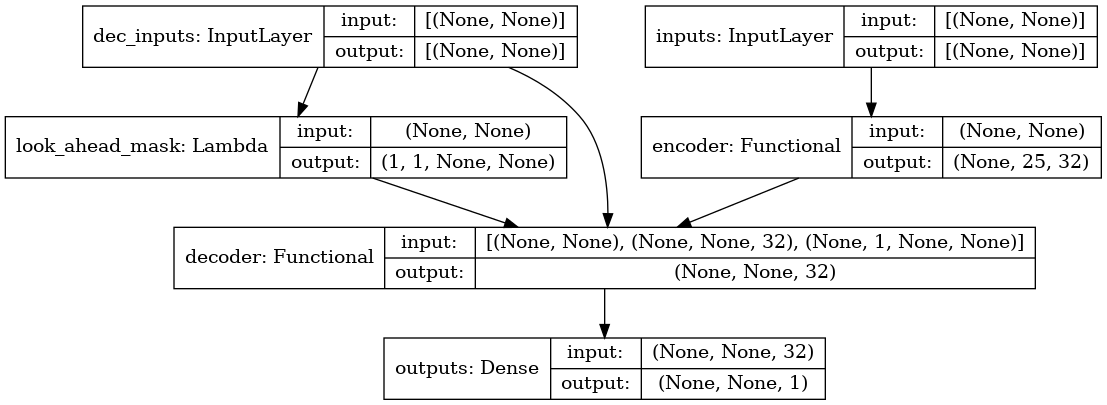

In [24]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
WINDOW_SIZE = 25
FORECAST_RANGE = 20
NUM_LAYERS = 4 #인코더, 디코더 수
DFF = 32 #트랜스포머 내부의 피드-포워드 신경망의 은닉층 크기(입력층, 출력층은 d_model) 
D_MODEL = 32 #인코더, 디코더에서의 정해진 출력 크기 = 임베딩 벡터의 차원
NUM_HEADS = 4 #트랜스포머 내 어텐션에서 여러개로 분할 후 병렬로 어탠션 수행함. 이때의 병렬의 수
DROPOUT = 0.1

model = transformer(
    window_size = WINDOW_SIZE,
    forecast_range = FORECAST_RANGE,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT,
    name="stock_transformer")

tf.keras.utils.plot_model(model, to_file='stock_transformer.png', show_shapes=True)

# 모델 학습!

In [100]:
#model.compile(optimizer = tf.keras.optimizers.Adam(),
#              loss = tf.keras.losses.MeanSquaredError(),
#              metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                       tf.keras.metrics.MeanAbsolutePercentageError()]
#             )
model.compile(optimizer = tf.keras.optimizers.Adam(0.005),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
             )

In [101]:
X_2.squeeze().shape

(166, 25)

In [102]:
history = model.fit(train_dataset, epochs=7, verbose = 1)

Epoch 1/7
260/260 [==============================] - 85s 326ms/step - loss: 0.5557 - mean_absolute_percentage_error: 57865.1833
Epoch 2/7
260/260 [==============================] - 84s 324ms/step - loss: 0.0097 - mean_absolute_percentage_error: 11846.3207
Epoch 3/7
260/260 [==============================] - 85s 327ms/step - loss: 0.0058 - mean_absolute_percentage_error: 13223.6621
Epoch 4/7
260/260 [==============================] - 85s 329ms/step - loss: 0.0040 - mean_absolute_percentage_error: 9765.9647
Epoch 5/7
260/260 [==============================] - 85s 328ms/step - loss: 0.0033 - mean_absolute_percentage_error: 9220.1018
Epoch 6/7
260/260 [==============================] - 85s 327ms/step - loss: 0.0025 - mean_absolute_percentage_error: 7191.2521
Epoch 7/7
260/260 [==============================] - 86s 329ms/step - loss: 0.0022 - mean_absolute_percentage_error: 7332.5994


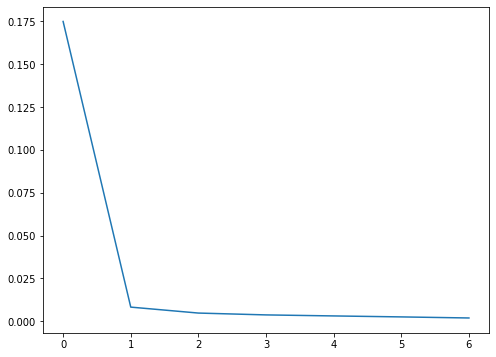

In [103]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot()

sp, ep = 0,7
x_range = np.arange(sp,ep)

ax1.plot(x_range,history.history["loss"][sp:ep],"C0-")

fig.savefig("loss_and_MAPE_tansformer.png")

# 예측 성능 보기

In [104]:
total_dataset_X[-1,:,:].reshape((1,-1))

array([[-0.90372164, -0.93203882, -0.98462779, -1.        , -0.91019412,
        -0.93365683, -0.81715208, -0.77912609, -0.70792875, -0.54935261,
        -0.50728153, -0.49595456, -0.45873781, -0.44498375, -0.56957915,
        -0.69417469, -0.82119733, -0.85517792, -0.66423935, -0.7273462 ,
        -0.77427176, -0.84870543, -0.91262136, -0.7710356 , -0.54611644]])

In [105]:
total_dataset_X[-1,:,:]

array([[-0.90372164],
       [-0.93203882],
       [-0.98462779],
       [-1.        ],
       [-0.91019412],
       [-0.93365683],
       [-0.81715208],
       [-0.77912609],
       [-0.70792875],
       [-0.54935261],
       [-0.50728153],
       [-0.49595456],
       [-0.45873781],
       [-0.44498375],
       [-0.56957915],
       [-0.69417469],
       [-0.82119733],
       [-0.85517792],
       [-0.66423935],
       [-0.7273462 ],
       [-0.77427176],
       [-0.84870543],
       [-0.91262136],
       [-0.7710356 ],
       [-0.54611644]])

In [106]:
def evaluate(inputs):
    
    #시작값(t시점)에서 시작!
    output = tf.constant(inputs[0,-1].reshape((1,-1)), dtype = tf.float32)

    # 디코더의 예측 시작
    for i in range(FORECAST_RANGE):
        forecasts = model(inputs=[inputs, output], training=False)

        # 현재 시점의 예측값을 받아온다.
        forecasts = forecasts[:, -1:, :]
        forecasts = tf.cast(forecasts, tf.float32)
        forecasts = tf.reshape(forecasts,(1,-1))

        # 현재 시점의 예측 값을 output(출력)에 연결한다.
        # output은 for문의 다음 루프에서 디코더의 입력이 된다.
        output = tf.concat([output, forecasts], axis=-1)

    # 예측이 모두 끝났다면 output을 리턴.
    return tf.squeeze(output, axis=0)

In [107]:
forecast = evaluate(total_dataset_X[-1,:,:].reshape((1,-1)))
forecast.numpy()

array([-0.5461165 , -0.53030014, -0.51247096, -0.49249402, -0.47448936,
       -0.45417964, -0.43662843, -0.41765115, -0.4008427 , -0.38217458,
       -0.36740008, -0.3482469 , -0.33107826, -0.3129286 , -0.2897285 ,
       -0.27160728, -0.25308105, -0.23100062, -0.21106875, -0.1965043 ,
       -0.18012895], dtype=float32)

In [108]:
total_dataset_Y[-1,:,:].reshape((1,-1))

array([[-0.54611644, -0.54045304, -0.69579285, -0.76537204, -0.56877022,
        -0.52912607, -0.53640764, -0.42799338, -0.49069577, -0.56957915,
        -0.48462775, -0.26860832, -0.40695792, -0.39482187, -0.30663416,
        -0.12135915, -0.14886725, -0.23948206, -0.3365695 , -0.29530734,
        -0.09546921]])

In [109]:
total_dataset_Y.shape

(16600, 21, 1)

In [110]:
def plot_forecast(fore_y, true_y, scaler=None, ax = None, length=20):
    x_range = np.arange(1,length+1,dtype = np.int32)
    
    forecast_1 = scaler.inverse_transform(fore_y.reshape((1,-1))) if scaler is not None else fore_y
    Y_2T_1 = scaler.inverse_transform(true_y.reshape((1,-1))) if scaler is not None else true_y
    
    if ax is None:
        plt.plot(x_range,Y_2T_1.squeeze()[1:])
        plt.plot(x_range,forecast_1.squeeze()[1:])
        return None
    else:
        ax_1 = ax
        ax_1.plot(x_range,Y_2T_1.squeeze()[1:])
        ax_1.plot(x_range,forecast_1.squeeze()[1:])
        return ax_1

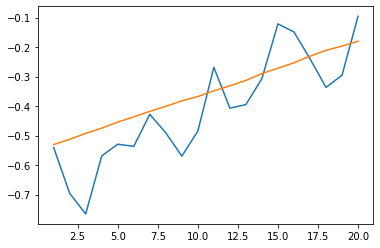

In [111]:
idx = -1

fig = plt.figure()

ax = fig.add_subplot()

forecast = evaluate(total_dataset_X[idx,:,:].reshape((1,-1)))
ax = plot_forecast(forecast.numpy(),total_dataset_Y[idx,:,:],ax=ax)



In [114]:
rand_list = []
while True:
    r = np.random.randint(0,total_dataset_Y.shape[0])
    if r not in rand_list:
        rand_list.append(r)
    if len(rand_list) >= 12:
        break
print(rand_list)

[2602, 11414, 6143, 7998, 3484, 5009, 7540, 8739, 6854, 12943, 6470, 14349]


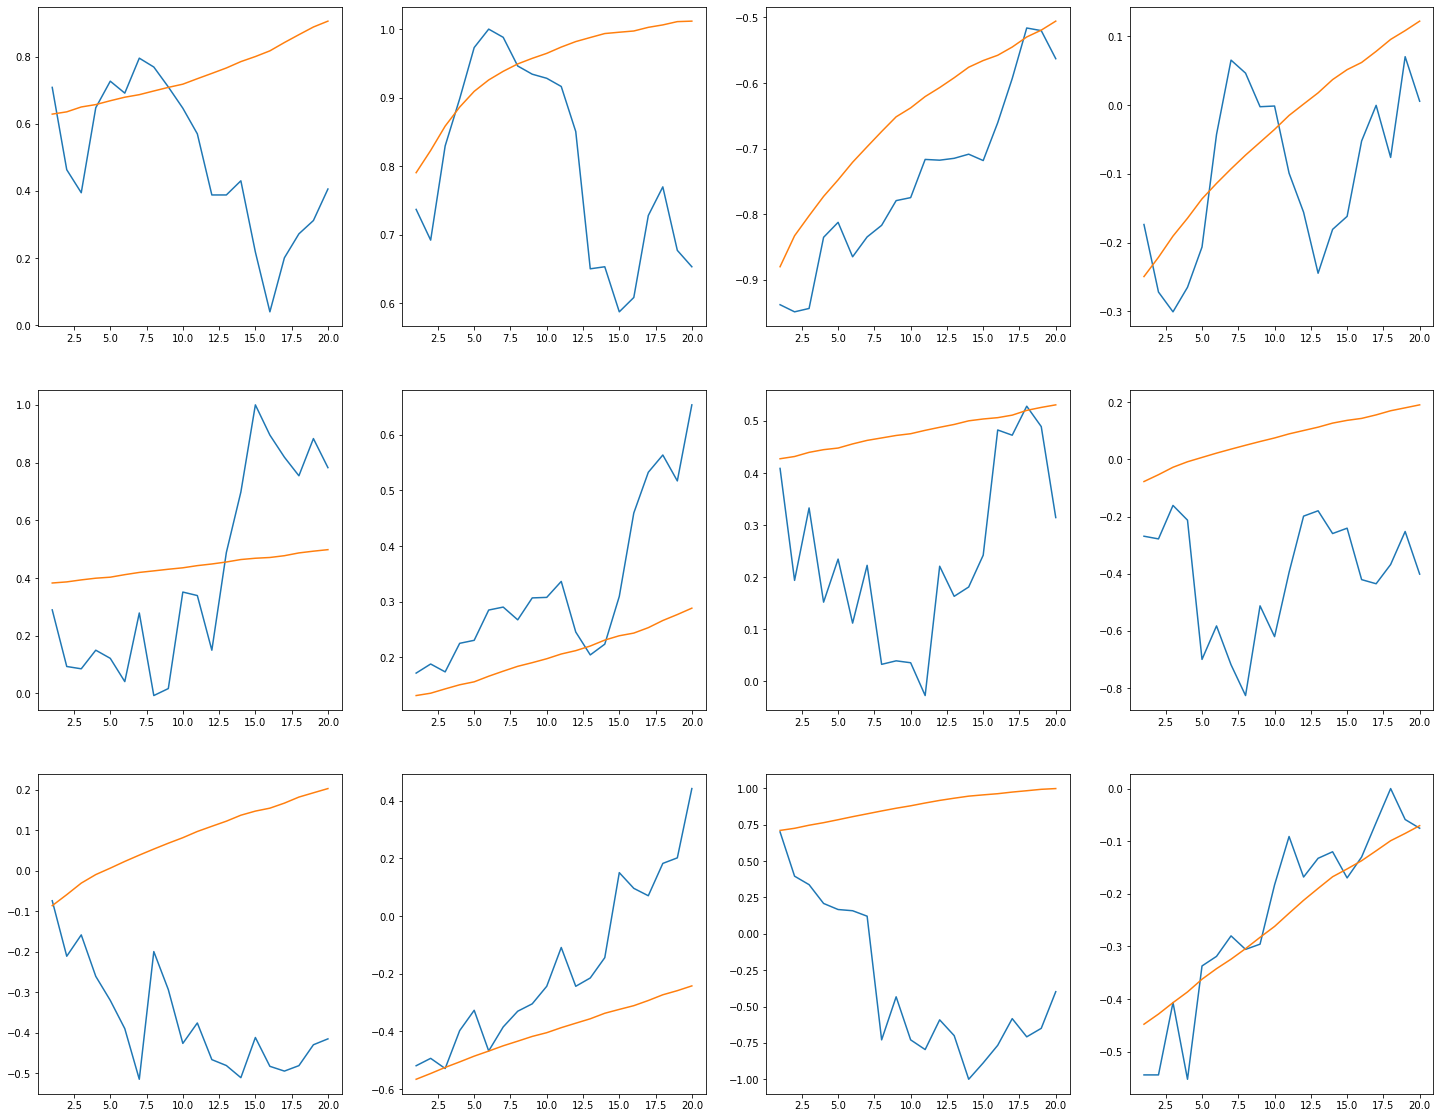

In [115]:
fig = plt.figure(figsize = (25,20))
ax_l = [fig.add_subplot(3,4,j) for j in range(1,13)]



for i in range(12):
    forecast = evaluate(total_dataset_X[rand_list[i],:,:].reshape((1,-1)))
    ax_l[i] = plot_forecast(forecast.numpy(),total_dataset_Y[rand_list[i],:,:],ax = ax_l[i])
    


# bootstrapping

In [149]:
from statsmodels.tsa.seasonal import STL
from scipy import stats 
from scipy.special import inv_boxcox
import arch
from arch.bootstrap import CircularBlockBootstrap,MovingBlockBootstrap
from numpy.random import standard_normal
from tqdm import tqdm

In [120]:
def block_bootstrap(ts, num, period_=7, seasonal_=13,print_lambda = False):
    """
    도저히 못찾아서 직접 만든 block bootstrap!
    파라미터:
        period : STL에 사용될 추세-주기 윈도우
        seasonal : STL에 사용될 계절성 윈도우
    """
    over_range_flag = False

    # box-cox변환
    x_trans,opti_lambda = stats.boxcox(ts)
    if opti_lambda > 5 or opti_lambda < -5:
        if print_lambda:
            print(opti_lambda)
        opti_lambda = -5 if opti_lambda < -5 else opti_lambda > 5
        x_trans = stats.boxcox(ts, lmbda=opti_lambda)
        over_range_flag = True

    #STL
    stl = STL(x_trans, period = period_, seasonal=seasonal_) 
    res = stl.fit()
    #fig = res.plot()

    #block bootstrapping to residual
    #bs = CircularBlockBootstrap(10, res.resid)
    bs = MovingBlockBootstrap(10, res.resid)
    for data in bs.bootstrap(num):
        bs_x = data[0][0]
        recomposed_series = res.trend + res.seasonal + bs_x
        #box-cox 역변환
        inv_x_trans = inv_boxcox(recomposed_series,opti_lambda)
        yield inv_x_trans

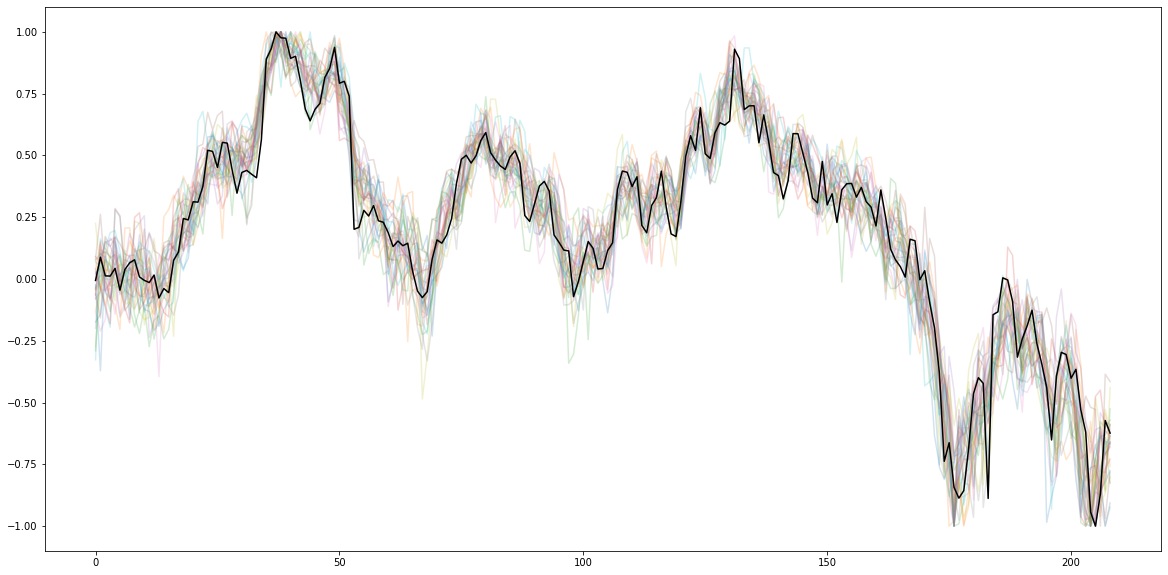

In [169]:
AMZN = pd.read_csv("./stock/asset/AMZN.csv")
ts = AMZN[['Date','Adj Close']]

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)

for bbs_ts in block_bootstrap(ts['Adj Close'], 30,print_lambda = True):
    bbs_pd = pd.DataFrame({'Date':ts.index,
                           'Adj Close':bbs_ts})
    
    bbs_asset = one_asset(bbs_pd,X_col=["Adj Close"],
                          window_size=25 ,
                          train_test_ratio = 1, 
                          is_minmaxscale = True)
    X,Y = bbs_asset.get_data()
    ax.plot(X.squeeze(),alpha = 0.2)
    
bbs_asset = one_asset(ts,X_col=["Adj Close"],
                      window_size=25 ,
                      train_test_ratio = 1,
                      is_minmaxscale = True)
X,Y = bbs_asset.get_data()
ax.plot(X.squeeze(),"black")


In [150]:
M6_Universe = pd.read_csv('M6_Universe.csv')

total_result = []
for asset in tqdm(M6_Universe.symbol):
    #파일 읽기
    ts = pd.read_csv(f"./stock/asset/{asset}.csv")['Adj Close']
    
    asset_forecast_list = []
    #부트스트래핑!
    for bbs_ts in block_bootstrap(ts, 30,print_lambda = True):
        #bbs_ts를 scaling
        bbs_scaler = MinMaxScaler(feature_range = (-1,+1))
        bbs_scaler.fit(bbs_ts.reshape((-1,1)))
        bbs_ts_scale = bbs_scaler.transform(bbs_ts.reshape((-1,1)))
        #sclae된 bbs_ts로 예측 
        forecast = evaluate(bbs_ts_scale[-25:,:].reshape((1,-1)))
        forecate_last = forecast.numpy()[-1]
        forecate_last = bbs_scaler.inverse_transform(forecate_last.reshape((1,1)))
        #결과 저장
        asset_forecast_list.append(forecate_last.squeeze())
    asset_forecast_np = np.array(asset_forecast_list).reshape((-1,1))
    total_result.append(asset_forecast_np)

total_result = np.concatenate(total_result,axis=1)
print(total_result.shape)


 11%|████▌                                     | 11/100 [04:58<40:22, 27.22s/it]

-5.36023222601018


 17%|███████▏                                  | 17/100 [07:40<37:32, 27.14s/it]

5.217995902008506


 53%|██████████████████████▎                   | 53/100 [24:01<21:22, 27.30s/it]

5.049391219904412


 54%|██████████████████████▋                   | 54/100 [24:28<20:50, 27.20s/it]

7.9049871210174025


 55%|███████████████████████                   | 55/100 [24:56<20:27, 27.27s/it]

8.062733069931678


 56%|███████████████████████▌                  | 56/100 [25:23<19:58, 27.23s/it]

5.38895197062633


 57%|███████████████████████▉                  | 57/100 [25:50<19:27, 27.15s/it]

5.492803089055228


 58%|████████████████████████▎                 | 58/100 [26:17<18:57, 27.10s/it]

6.386327386714979


 62%|██████████████████████████                | 62/100 [28:07<17:19, 27.36s/it]

6.497153861180347


 67%|████████████████████████████▏             | 67/100 [30:24<15:04, 27.42s/it]

9.836139661367708


 68%|████████████████████████████▌             | 68/100 [30:51<14:36, 27.40s/it]

19.718348723123654


 69%|████████████████████████████▉             | 69/100 [31:18<14:09, 27.39s/it]

36.88308607149462


 70%|█████████████████████████████▍            | 70/100 [31:46<13:39, 27.31s/it]

13.047480713090145


 71%|█████████████████████████████▊            | 71/100 [32:13<13:13, 27.36s/it]

6.831064367744191


 72%|██████████████████████████████▏           | 72/100 [32:40<12:47, 27.39s/it]

9.483492898518694


 73%|██████████████████████████████▋           | 73/100 [33:07<12:16, 27.26s/it]

16.597228378463655


 74%|███████████████████████████████           | 74/100 [33:35<11:47, 27.20s/it]

21.104983208605702


 75%|███████████████████████████████▌          | 75/100 [34:01<11:18, 27.12s/it]

8.81297294584898


 76%|███████████████████████████████▉          | 76/100 [34:29<10:51, 27.13s/it]

-5.89803062026396


 79%|█████████████████████████████████▏        | 79/100 [35:50<09:31, 27.24s/it]

8.01606857197783


 82%|██████████████████████████████████▍       | 82/100 [37:13<08:13, 27.39s/it]

-12.323402738499219


 83%|██████████████████████████████████▊       | 83/100 [37:40<07:43, 27.28s/it]

5.0670830424342475


 90%|█████████████████████████████████████▊    | 90/100 [40:51<04:33, 27.37s/it]

5.928396564252919


 94%|███████████████████████████████████████▍  | 94/100 [42:40<02:43, 27.23s/it]

12.042529741005437


 97%|████████████████████████████████████████▋ | 97/100 [44:02<01:22, 27.35s/it]

-5.201649927536528


 98%|█████████████████████████████████████████▏| 98/100 [44:30<00:54, 27.33s/it]

6.492294708701283


100%|█████████████████████████████████████████| 100/100 [45:24<00:00, 27.25s/it]

(30, 100)


In [151]:
total_result_pd = pd.DataFrame(total_result,columns = M6_Universe.symbol)
total_result_pd.to_csv("bbs_adj.csv",index=False)

In [154]:
T_list = []
for asset in tqdm(M6_Universe.symbol):
    ts = pd.read_csv(f"./stock/asset/{asset}.csv")['Adj Close']
    T_list.append(ts.iloc[-1])
len(T_list)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 586.46it/s]


100

In [157]:
np.log(T_list)

array([5.00038293, 5.66299524, 4.54701126, 5.13426789, 4.63850824,
       4.62173226, 5.50150307, 4.80745774, 5.28952886, 5.16649881,
       5.03050324, 5.48947479, 4.26577369, 4.28977423, 5.05107323,
       3.65065824, 5.13638654, 4.73039212, 6.18559117, 4.51019998,
       3.39114707, 4.47881297, 5.98325598, 3.75302731, 5.51266231,
       5.98963785, 4.08916448, 3.4339872 , 5.1314951 , 4.06765827,
       4.68545902, 4.97321034, 4.15543964, 2.82849636, 4.74284301,
       3.83384526, 3.46448509, 4.96298451, 3.307985  , 4.55923098,
       4.39506629, 5.60558146, 3.59649004, 4.42172798, 6.25653663,
       5.61418597, 5.36457315, 5.21916592, 3.72158867, 4.46682726,
       5.98454061, 5.19023089, 3.38912478, 3.1320099 , 3.74478707,
       3.41707072, 3.91122267, 4.00186372, 3.92868345, 3.93885967,
       3.7164946 , 4.06851382, 3.07961376, 3.04785021, 3.26001774,
       3.51838764, 3.87722452, 4.73294753, 4.34237582, 4.41715244,
       4.64650406, 4.77533484, 4.59744042, 1.58790776, 1.61163

In [163]:
result_return = np.log(total_result)-np.log(T_list)
result_return_pd = pd.DataFrame(result_return,columns=M6_Universe.symbol)
result_return_pd.to_csv("asset_return_transformer.csv",index = False)

In [181]:
#AMZN에 nan이 많다! 적을때 까지 처리!!
ts = pd.read_csv("./stock/asset/AMZN.csv")['Adj Close']
asset_forecast_list = []
for bbs_ts in block_bootstrap(ts, 30,print_lambda = True):
    #bbs_ts를 scaling
    bbs_scaler = MinMaxScaler(feature_range = (-1,+1))
    bbs_scaler.fit(bbs_ts.reshape((-1,1)))
    bbs_ts_scale = bbs_scaler.transform(bbs_ts.reshape((-1,1)))
    #sclae된 bbs_ts로 예측 
    forecast = evaluate(bbs_ts_scale[-25:,:].reshape((1,-1)))
    forecate_last = forecast.numpy()[-1]
    forecate_last = bbs_scaler.inverse_transform(forecate_last.reshape((1,1)))
    #결과 저장
    asset_forecast_list.append(forecate_last.squeeze())
asset_forecast_np = np.array(asset_forecast_list).reshape((-1,1))
asset_forecast_np

array([[141.8765 ],
       [140.70639],
       [140.28377],
       [147.74374],
       [139.27905],
       [141.82664],
       [143.57135],
       [129.62451],
       [143.71635],
       [139.37125],
       [124.65733],
       [137.68764],
       [136.39194],
       [146.56982],
       [135.32489],
       [142.77275],
       [      nan],
       [143.07726],
       [141.55669],
       [143.1598 ],
       [146.34702],
       [139.9525 ],
       [144.70854],
       [144.4888 ],
       [132.21257],
       [143.69405],
       [143.38431],
       [141.65164],
       [143.50427],
       [141.0709 ]], dtype=float32)

In [185]:
asset_forecast_np = np.log(asset_forecast_np)-np.log(ts.iloc[-1])

In [186]:
result_return_pd2 = result_return_pd.copy()
result_return_pd2['AMZN'] = asset_forecast_np
result_return_pd2.to_csv("asset_return_transformer2.csv",index = False)